In [5]:
!pip install -Uqq fastbook

In [7]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in dl-lab2
- `Resize(420)` as item transform
- A size of 224 in the batch transforms
- Use `set_seed()` to obtain reproducible results.
- Augmentations using `aug_transforms()` with `min_scale` and `mult` set to a value that creates resonable augmentations (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [13]:
fastbook.setup_book()
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks')
export_path.ls()

(#3) [Path('/content/gdrive/MyDrive/Colab Notebooks/lotus_roadster_ddg_23'),Path('/content/gdrive/MyDrive/Colab Notebooks/lotus_tesla_ddg_23'),Path('/content/gdrive/MyDrive/Colab Notebooks/digits')]

In [34]:
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

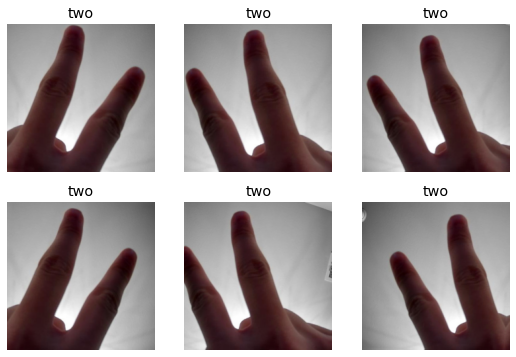

In [35]:
dls.train.show_batch(nrows=2, ncols=3, unique=True)

### Question 1: Which `min_scale` and `mult` values did you choose for augmentations? Can you spot any problems in the training set augmentations, e.g. finger digits missing?
I chose a min_scale of 2 and a mult of 0.3 from what I can see there is slight cutout on the bottom row middle image, but not to the degree where all fingers are not visible.


# 2. Train the classifier

## 2.1 Impact of learning rate
With:
- Same `set_seed()` as above
- Re-creating the same DataLoaders as above
- ResNet18 architecture.
- accuracy as metric.

Use the learning rate finder and identify three learning rates:
- small: In the flat region prior to descending
- medium: What the textbook would recommend
- large: Close to the minimum of the learning rate finder

Train the model with each learning rate using `fine_tune` with 15 epochs


In [39]:
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)

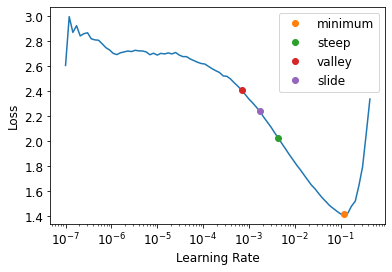

In [44]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [45]:
print(f"Minimum/10:\t{lr_min:.2e}")
print(f"Steepest point:\t{lr_steep:.2e}")
print(f"Longest valley:\t{lr_valley:.2e}")

Minimum/10:	1.20e-02
Steepest point:	4.37e-03
Longest valley:	6.92e-04


In [46]:
### Small - Right before slope/descent
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=lr_valley)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.592435,2.392485,0.280000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,2.436687,1.985590,0.280000,00:04
1,2.377676,1.768474,0.320000,00:04
2,2.235874,1.614131,0.340000,00:05
3,2.117490,1.394738,0.480000,00:04
4,1.945114,1.162748,0.480000,00:06
5,1.807193,1.022179,0.540000,00:05
6,1.682154,0.918580,0.600000,00:05
7,1.561515,0.854699,0.580000,00:05
8,1.447350,0.803583,0.660000,00:04
9,1.346289,0.748936,0.660000,00:03


In [47]:
### Medium - In the midst of the slope/textbook recommendation
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=lr_steep)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.444417,2.177342,0.320000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.585928,1.572855,0.460000,00:03
1,1.403344,1.383121,0.540000,00:03
2,1.220215,1.341944,0.620000,00:04
3,1.034555,1.145046,0.680000,00:05
4,0.897655,0.872600,0.800000,00:03
5,0.785426,1.111187,0.700000,00:03
6,0.697375,0.847024,0.780000,00:05
7,0.615417,0.679777,0.840000,00:03
8,0.551702,0.637099,0.840000,00:03
9,0.499193,0.635331,0.860000,00:03


In [48]:
### Large - Minimum of the learning rate graph
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=lr_min)

epoch,train_loss,valid_loss,accuracy,time
0,2.310765,3.390461,0.380000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.396073,2.337906,0.460000,00:03
1,1.156435,1.396725,0.620000,00:05
2,0.929581,1.157683,0.680000,00:03
3,0.778244,1.469038,0.680000,00:03
4,0.665749,2.137376,0.660000,00:04
5,0.593689,1.879490,0.780000,00:04
6,0.540225,1.424569,0.780000,00:03
7,0.476187,1.167053,0.780000,00:03
8,0.442483,0.990471,0.800000,00:05
9,0.412962,1.279066,0.760000,00:03


### Question 2: Which training run resulted in the best model? State final accuracy values for all learning rates and identify the best model. 
- lr of 6.92e-4 accuracy = 74%
- lr of 1.2e-2 accuracy = 84%
- lr of 4.37e-3 accuracy = 88%

Focusing on accuracy alone a medium lr provided the highest ending accuracy at 15epochs, however at 11 epochs for the medium lr actually provided an accuracy of 90% over the 88% that the model closed in on as the epochs continued to grow.


### Question 3: Did any models overfit? Include your reasoning. 
Yes lr=4.37e-3 or the medium lr model had overfitting issues. This is evident because the validation loss ends stagnating around 0.6 but the training loss decreases lower to about 0.3. This shows the model is getting too comfortable with the training set and not being able to predict new images well.

## 2.2 Impact of freeze epoch
With:
- Same `set_seed()` as above
- Re-creating the same DataLoaders as above
- ResNet18 architecture.
- accuracy as metric.
- learning rate of the best model from above

Create three model training with `fine_tune()` that use different combinations of `freeze_epochs` and `epochs` with the total number of epochs not exceeding 16 (number of epochs from the previous section).

In [52]:
## Try freezing at 10, 5, and 12
## Not using lr_steep due to overfitting previously discussed
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5, freeze_epochs=10, base_lr=lr_min)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.457153,2.329791,0.340000,00:04
1,2.191317,1.766353,0.420000,00:04
2,1.896267,1.877819,0.500000,00:04
3,1.627119,2.068113,0.540000,00:05
4,1.400161,1.801928,0.580000,00:03
5,1.223447,1.350440,0.640000,00:03
6,1.091046,1.205016,0.700000,00:03
7,0.973188,1.164437,0.700000,00:04
8,0.876374,1.013837,0.740000,00:03
9,0.803319,0.942956,0.720000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.344748,1.139782,0.720000,00:04
1,0.384288,3.452039,0.640000,00:04
2,0.530562,3.026600,0.660000,00:03
3,0.588260,2.456379,0.740000,00:03
4,0.537041,1.728875,0.800000,00:04


In [54]:
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, freeze_epochs=5, base_lr=lr_min)

epoch,train_loss,valid_loss,accuracy,time
0,2.446172,2.295870,0.340000,00:03
1,2.085788,2.145293,0.480000,00:03
2,1.718661,2.560419,0.560000,00:04
3,1.456958,2.494973,0.540000,00:06
4,1.241708,1.870655,0.620000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.417737,1.453975,0.640000,00:03
1,0.430300,1.050628,0.800000,00:04
2,0.421890,1.401319,0.720000,00:03
3,0.437699,2.348195,0.620000,00:03
4,0.423126,5.787037,0.580000,00:05
5,0.486078,2.534301,0.600000,00:03
6,0.488714,1.409749,0.700000,00:03
7,0.440137,1.084346,0.760000,00:03
8,0.400465,0.961758,0.720000,00:05
9,0.373479,0.883603,0.740000,00:03


In [55]:
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4, freeze_epochs=12, base_lr=lr_min)

epoch,train_loss,valid_loss,accuracy,time
0,2.458303,2.335088,0.320000,00:03
1,2.206742,1.762268,0.400000,00:03
2,1.928705,1.757921,0.500000,00:04
3,1.666831,1.932071,0.540000,00:03
4,1.442793,1.767718,0.600000,00:03
5,1.260374,1.404280,0.620000,00:03
6,1.124495,1.173061,0.660000,00:04
7,1.000777,1.086649,0.680000,00:03
8,0.901384,0.959504,0.720000,00:03
9,0.824208,0.936050,0.720000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.353716,0.867070,0.780000,00:03
1,0.480665,3.415793,0.480000,00:04
2,0.590731,3.280271,0.560000,00:04
3,0.582970,2.394277,0.660000,00:03


### Question 4: Did any of these models outperform the models in Section 2.1? State final accuracy values for epoch combinations and identify the best model, compare to best model in section 2.1. 
None of the models outperformed the one in section 2.1.

The final accuracy results are as follows for total epochs 15
- freeze 10 accuracy = 80%
- freeze 5 accuracy = 74%
- freeze 12 accuracy = 66%

the best model was freezing at 10 epochs and running the final 5. The accuracy difference was 80 for the frozen and 84 for the straight 15.


### Question 5: Did any models overfit? Include your reasoning. 
All three seemed to overfit as the training set loss decreased but the validation loss greatly increased.


# 3. Analyze model performance
- Retrain the best model from above.
- Plot the confusion matrix.
- Plot 10 top losses

In [56]:
set_seed(82,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=82),
                 get_y=parent_label,
                 item_tfms=Resize(420),
                 batch_tfms=aug_transforms(size=224, min_scale=2, mult=0.3))
dls = digits.dataloaders(export_path/'digits')

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=lr_min)

epoch,train_loss,valid_loss,accuracy,time
0,2.310765,3.390461,0.380000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.396073,2.337906,0.460000,00:07
1,1.156435,1.396725,0.620000,00:07
2,0.929581,1.157683,0.680000,00:05
3,0.778244,1.469038,0.680000,00:09
4,0.665749,2.137376,0.660000,00:06
5,0.593689,1.879490,0.780000,00:07
6,0.540225,1.424569,0.780000,00:03
7,0.476187,1.167053,0.780000,00:03
8,0.442483,0.990471,0.800000,00:04
9,0.412962,1.279066,0.760000,00:06


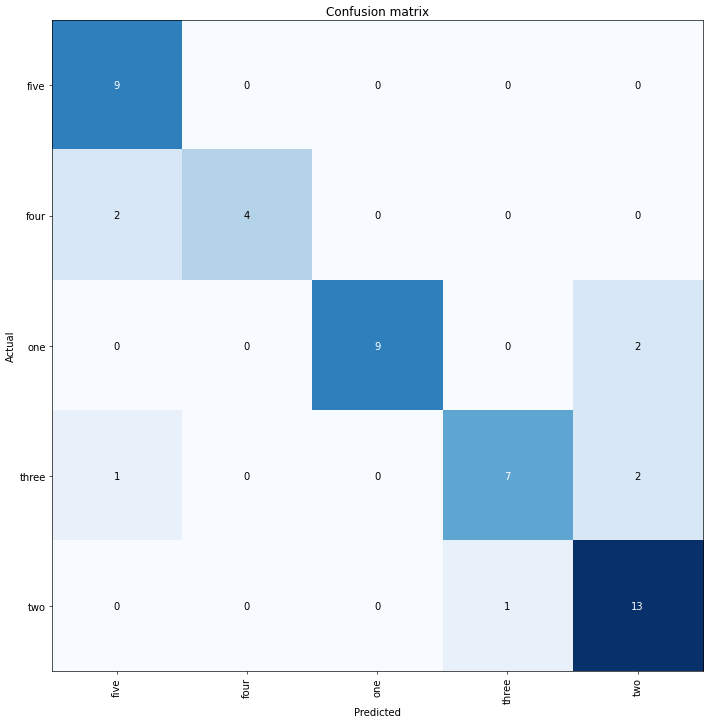

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

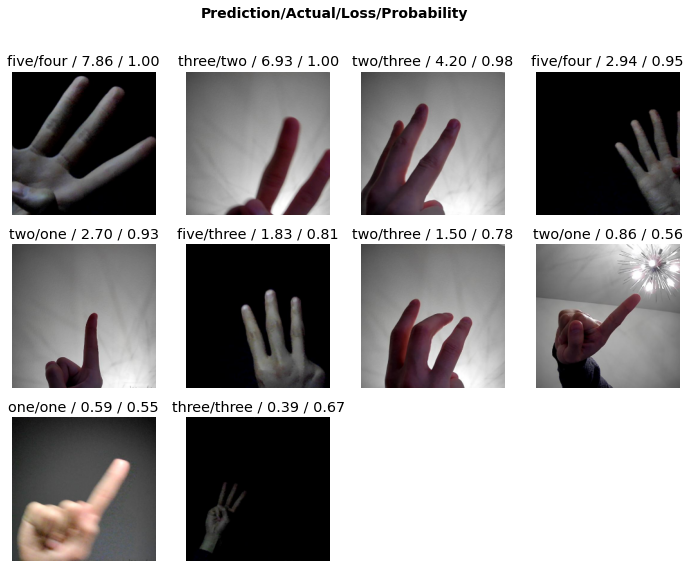

In [59]:
interp.plot_top_losses(10, nrows=3, ncols=4)

### Question 6: With which finger digits does your model have the most problems with? 
My model had issues with four, three, and one digits. The model struggled most with was three digits as shown in the top 10 losses. There were four images with three digits that it struggled with.

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

# 5. Summary and Conclusion

Summarize the best model:
- Training strategy: learning rate and epochs used.
- Accuracy achieved, summary of confusion matrix, i.e. what kind of errors does the model make.

*YOUR ANSWER HERE*


Conclusion:
- Are you satisfied with model performance? Why, why not?

*YOUR ANSWER HERE*


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

*YOUR ANSWER HERE*
